In [33]:
'''Testing the Chopin repo for debugging'''

import warnings; warnings.simplefilter('ignore')  # hide warnings

from matplotlib import pyplot as plt
import numpy as np

np.random.seed(0)

from particles import distributions as dists

prior_dict = {
              'rho': dists.Uniform(a=-1., b=1.),
              'sigmaX':dists.Gamma(2,2),
              'sigmaY':dists.Gamma(2,2)}
my_prior = dists.StructDist(prior_dict)

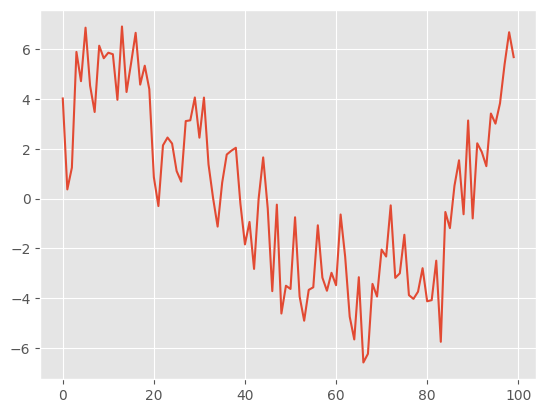

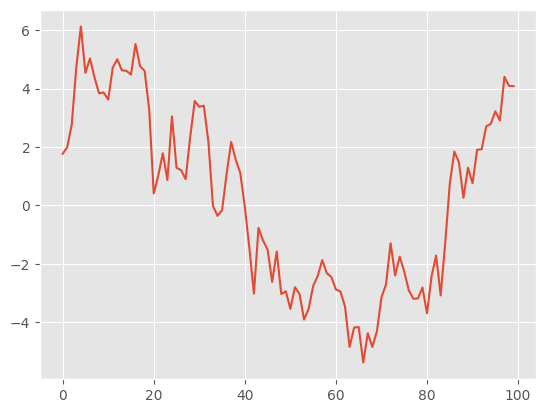

In [34]:
from particles import state_space_models as ssm


class TestModel(ssm.StateSpaceModel):
    default_parameters = {'rho':0.9, 'sigmaX': 1.,'sigmaY':1.2}
    def PX0(self):  # Distribution of X_0
        return dists.Normal(loc=0., scale=self.sigmaX)
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return dists.Normal(self.rho * xp, scale=self.sigmaX)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
        return dists.Normal(loc=x, scale=self.sigmaY)
    

my_model = TestModel(rho = 0.9,sigmaX = 1.,sigmaY = 1.2)  # actual model
true_states, data = my_model.simulate(100)  # we simulate from the model 100 data points

plt.style.use('ggplot')
plt.figure()
plt.plot(data)
plt.show()

plt.plot(true_states)
plt.show()

In [35]:
from particles import mcmc
from particles import datasets as dts  # real datasets available in the package


my_pmmh = mcmc.PMMH(ssm_cls=TestModel, prior=my_prior, data=data, Nx=1000,
                    niter=1000,adaptive=True)

my_pmmh.run();  # may take several seconds...

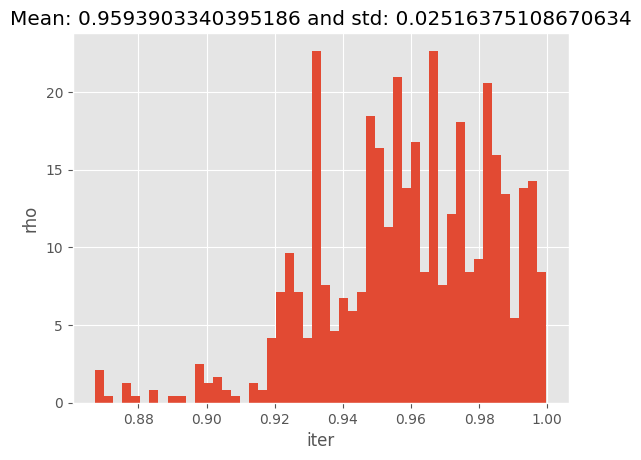

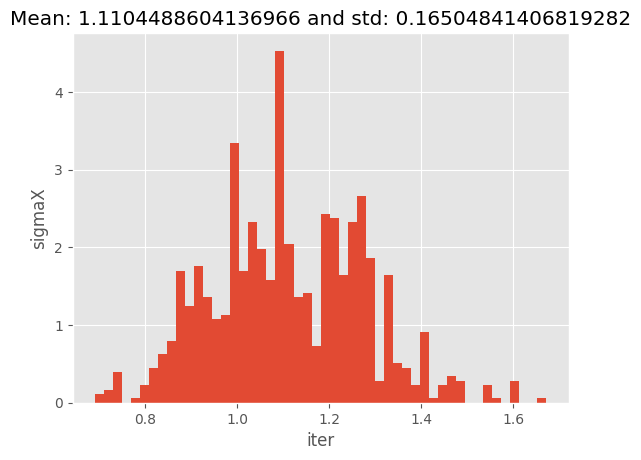

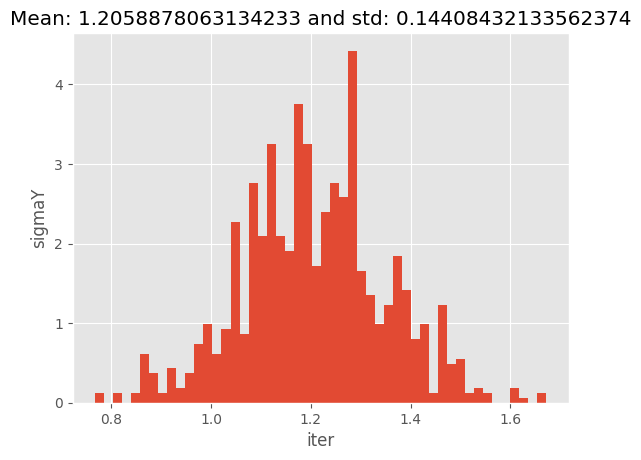

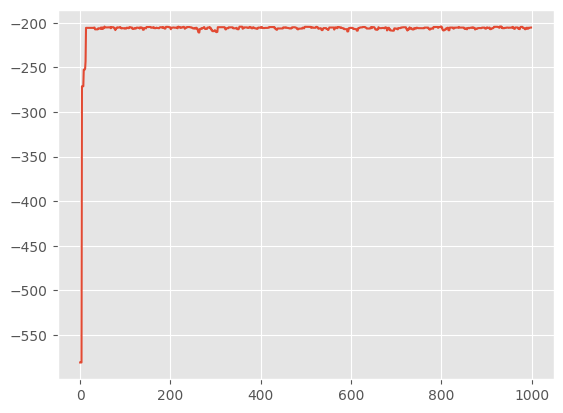

In [36]:
burn_in = 100

for p in prior_dict.keys():  # loop over mu, theta, rho
    plt.figure()
    plt.title(f"Mean: {np.mean(my_pmmh.chain.theta[p][burn_in:])} and std: {np.std(my_pmmh.chain.theta[p][burn_in:])}")
    plt.hist(my_pmmh.chain.theta[p][burn_in:],density=True,bins = 50)
    plt.xlabel('iter')
    plt.ylabel(p)
    plt.show()

plt.plot(my_pmmh.chain.lpost)